## Calculating % Clay in topsoil for SSURGO map unit

There are multiple tables from SSURGO involved. First the files per county have to be downloaded and unzipped under corresponding folders in this repo. The approach is to use a weighted average of soil horizons *chorizon* table for the average clay content (_r) per that layer, layer thickness, the % clay was recalculated to 50 cm (hardcoded) - per soil *component*.
Then, the *chorizon" table has to be merged with *  * table on cokey (one-to-many) since the extent of the soil component within map unit (mukey) varies. Weighted average of the clay per mapunit was calculated in the same way.
The clay % per map unit tables were merged for all four counties - that table then merged with soil shapefile in ArcMap.
The soil shapefile was spatially cut to the farm fields extent - another weighted average of % clay was done depending on the % of mapunits composing the ricefield

In [1]:
# import needed modules
import pandas as pd
import numpy as np
import os
# usefull to see and scroll through bigger dframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# constructing path to file
'''
all reside under tabular\ subfolder in ST\ST001 structure
Note: if you want to include \ while constructing path, add them at the beginning of the text chunk
'''
state = '\AR'
county = '\AR043'
chorizon = '\chorizon.txt'

horz_path = 'C:\c_repos\soils-ssurgo\SSURGO' +  state + county + '\\tabular' + chorizon

print(horz_path)


C:\c_repos\soils-ssurgo\SSURGO\AR\AR043\tabular\chorizon.txt


In [112]:
#loading CHORIZON table into df
'''
The Horizon table lists the horizon(s) and related data for the referenced map unit component. If the horizon thickness is greater than zero (low=5, RV=8, high=12), the horizon exists everywhere this
component occurs. If the horizon thickness includes zero (low=0, RV=1, high=3), the horizon may exist in some places, but not in other places.
Horizons that have two distinct parts, such as E/B or E&Bt horizons, are recorded twice. Once for the characteristics of the first part; and again on another row, using the same depths and thicknesses,
for the characteristics of the other part.

the .txt tables are of CSV type, but pipe | delimited, those tables do not have headers, the general header names have to be pulled out from  pdf, since there are 171 columns,
we will select only need columns by index, and load pre-defined headers from the list

_r indicates representative value of the property for soil horizon, original table also includes _l (lowest) and _h (highest) values for the property
horizon depth and thickness is in CM, clay and organic matter total are in %
'''
col_chorizon = ['hzname', 'hzdept_r_cm', 'hzdepb_r_cm', 'hzthk_r_cm', 'claytotal_r_%', 'om_r_%', 'cokey', 'chkey']

df_chorizon = pd.read_csv(horz_path, delimiter='|', index_col=False, usecols=[0, 6, 9, 12, 60, 66, 169, 170], names=col_chorizon)
df_chorizon.head(3)

,hzname,hzdept_r_cm,hzdepb_r_cm,hzthk_r_cm,claytotal_r_%,om_r_%,cokey,chkey
0,Btg1,61,102,41,28.0,0.75,21856317,64452141
1,A,0,8,8,15.0,1.75,21856317,64452142
2,Btg2,102,142,40,23.5,0.25,21856317,64452143


In [113]:
df_chorizon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hzname         154 non-null    object 
 1   hzdept_r_cm    154 non-null    int64  
 2   hzdepb_r_cm    154 non-null    int64  
 3   hzthk_r_cm     154 non-null    int64  
 4   claytotal_r_%  154 non-null    float64
 5   om_r_%         154 non-null    float64
 6   cokey          154 non-null    int64  
 7   chkey          154 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 9.8+ KB


In [114]:
# this assigns 0 values of claycontent to all horizons where bottom is > 50 cm - this will also exclude clay value if top of the layer <50 cm, but bottom deeper, which is OK fo now - but see if this
# can be improved further, or looking for clay content in top 30 cm

df_chorizon['clay%_50cm'] = np.where(df_chorizon['hzdepb_r_cm']>50, 0, (df_chorizon['hzdepb_r_cm'] - df_chorizon['hzdept_r_cm'])/50 * df_chorizon['claytotal_r_%'])

In [115]:
df_chorizon.describe()

,hzdept_r_cm,hzdepb_r_cm,hzthk_r_cm,claytotal_r_%,om_r_%,cokey,chkey,clay%_50cm
count,154.00000,154.000000,154.000000,154.000000,154.000000,1.540000e+02,1.540000e+02,154.000000
mean,48.25974,97.928571,49.668831,23.636364,0.708442,2.185632e+07,6.445215e+07,1.420000
std,48.65079,66.900776,33.466021,13.405597,0.546642,3.188757e+01,4.460007e+01,2.784204
min,0.00000,5.000000,5.000000,7.000000,0.000000,2.185627e+07,6.445207e+07,0.000000
25%,0.00000,30.000000,18.000000,14.000000,0.250000,2.185630e+07,6.445211e+07,0.000000
50%,28.00000,84.000000,46.000000,22.250000,0.500000,2.185632e+07,6.445215e+07,0.000000
75%,78.25000,152.000000,69.000000,27.500000,1.250000,2.185635e+07,6.445219e+07,2.400000
max,183.00000,216.000000,160.000000,72.500000,2.500000,2.185637e+07,6.445223e+07,18.000000


In [116]:
# another way to summarize per cokey - just get only info from the top horizon

df_A_horz = df_chorizon.loc[df_chorizon['hzdept_r_cm'] == 0]

df_A_horz.describe()

,hzdept_r_cm,hzdepb_r_cm,hzthk_r_cm,claytotal_r_%,om_r_%,cokey,chkey,clay%_50cm
count,41.0,41.000000,41.000000,41.000000,41.000000,4.100000e+01,4.100000e+01,41.000000
mean,0.0,21.243902,21.243902,16.743902,1.500000,2.185632e+07,6.445215e+07,4.367805
std,0.0,16.939275,16.939275,9.494816,0.362284,3.223914e+01,4.495084e+01,3.398910
min,0.0,5.000000,5.000000,7.000000,1.250000,2.185627e+07,6.445208e+07,0.000000
25%,0.0,10.000000,10.000000,12.500000,1.250000,2.185630e+07,6.445211e+07,2.550000
50%,0.0,15.000000,15.000000,15.000000,1.250000,2.185632e+07,6.445215e+07,4.200000
75%,0.0,23.000000,23.000000,17.500000,1.750000,2.185635e+07,6.445218e+07,5.720000
max,0.0,71.000000,71.000000,60.000000,2.500000,2.185637e+07,6.445222e+07,18.000000


In [117]:
# summarize clay%_50cm pey cokey

df_cokey = df_chorizon.groupby('cokey', as_index=False).agg({'clay%_50cm': sum})
df_cokey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cokey       41 non-null     int64  
 1   clay%_50cm  41 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 784.0 bytes


In [118]:
df_cokey.describe()

,cokey,clay%_50cm
count,4.100000e+01,41.000000
mean,2.185632e+07,5.333659
std,3.223914e+01,4.165995
min,2.185627e+07,0.000000
25%,2.185630e+07,2.800000
50%,2.185632e+07,4.370000
75%,2.185635e+07,6.900000
max,2.185637e+07,18.000000


In [119]:
# load COMPONENT table (comp.txt) and link % Clay 50 to soil component 
comp = '\comp.txt'

com_path = 'C:\c_repos\lv_soils\SSURGO' +  state + county + '\\tabular' + comp

print(com_path)


C:\c_repos\lv_soils\SSURGO\AR\AR043\tabular\comp.txt


In [120]:
#loading soil COMPONENT table into df
'''

'''
col_comp = ['comppct_r','compname', 'compkind', 'majcompflag', 'taxclname', 'mukey', 'cokey']

df_comp = pd.read_csv(com_path, delimiter='|', index_col=False, usecols=[1, 3, 4, 5, 82, 107, 108], names=col_comp)
df_comp.head(3)

,comppct_r,compname,compkind,majcompflag,taxclname,mukey,cokey
0,3,Pheba,Series,No,"Coarse-silty, siliceous, active, thermic Glossaquic Fragiudults",565443,21856316
1,95,Amy,Series,Yes,"Fine-silty, siliceous, semiactive, thermic Typic Endoaquults",565443,21856317
2,2,Aquults,Taxon above family,No,Aquults,565443,21856318


In [121]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comppct_r    114 non-null    int64 
 1   compname     114 non-null    object
 2   compkind     110 non-null    object
 3   majcompflag  114 non-null    object
 4   taxclname    55 non-null     object
 5   mukey        114 non-null    int64 
 6   cokey        114 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 6.4+ KB


In [122]:
# merge %clay in 50 cm

df_clay_comp = df_comp.merge(df_A_horz, on='cokey', how='left')

df_clay_comp.head()

,comppct_r,compname,compkind,majcompflag,taxclname,mukey,cokey,hzname,hzdept_r_cm,hzdepb_r_cm,hzthk_r_cm,claytotal_r_%,om_r_%,chkey,clay%_50cm
0,3,Pheba,Series,No,"Coarse-silty, siliceous, active, thermic Glossaquic Fragiudults",565443,21856316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95,Amy,Series,Yes,"Fine-silty, siliceous, semiactive, thermic Typic Endoaquults",565443,21856317,A,0.0,8.0,8.0,15.0,1.75,64452142.0,2.4
2,2,Aquults,Taxon above family,No,Aquults,565443,21856318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,Amy,Series,Yes,"Fine-silty, siliceous, semiactive, thermic Typic Endoaquults",565444,21856345,A,0.0,8.0,8.0,15.0,1.75,64452180.0,2.4
4,5,Aquults,Taxon above family,No,Thermic Aquults,565444,21856346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# calculate % clay per MUKEY
# making weighted clay value per MUKEY

df_clay_comp['clay%_mu'] = df_clay_comp['claytotal_r_%'] * df_clay_comp['comppct_r'] / 100

In [124]:
# summary of clay per MUKEY
df_mukey = df_clay_comp.groupby('mukey', as_index=False).agg({'clay%_mu': sum})



<AxesSubplot:>

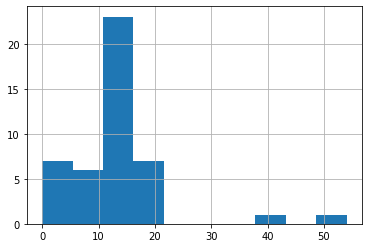

In [125]:
df_mukey['clay%_mu'].hist()

In [126]:
df_mukey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mukey     45 non-null     int64  
 1   clay%_mu  45 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 848.0 bytes


In [127]:
df_mukey.describe()

,mukey,clay%_mu
count,4.500000e+01,45.000000
mean,6.654422e+05,12.918889
std,3.237066e+05,9.319205
min,5.654430e+05,0.000000
25%,5.654540e+05,9.025000
50%,5.654650e+05,12.500000
75%,5.654760e+05,15.750000
max,1.690251e+06,54.000000


In [128]:
# save all summary tables in Excel file per county
# Write multiple DataFrames to Excel file - version removed duplicates???
with pd.ExcelWriter('..\SSURGO\AR\AR043_soils.xlsx') as writer:    
    df_mukey.to_excel(writer, sheet_name='mukey_clay', index=False) 
    df_clay_comp.to_excel(writer, sheet_name='cokey_soil', index=False)
    df_A_horz.to_excel(writer, sheet_name='A_horizon', index=False) 
    df_chorizon.to_excel(writer, sheet_name='all_horizons', index=False)   


In [129]:
# copy df_mukey to county specific

df_AR043_muclay = df_mukey.copy()

Repeat the above for each county in question.

In [131]:
# merge dfs of % Clay per mukey of all counties

dfs_lst = ['df_AR003_muclay', 'df_AR017_muclay', 'df_AR041_muclay', 'df_AR043_muclay']

def join_dfs(dfs_list):
    df1 = pd.DataFrame()
    n = 0

    for df in range(len(dfs_list)):
        if df1.empty:
            df1 = dfs_list[n]
            n+=1
        else:
            df2 = dfs_list[n+1]
            df1 = df1.append(df2, ignore_index=True, sort = True) # sort = True is added after received warning about further versions of Anaconda/Pandas
            n+=1
    return df1


In [133]:
df_mu2 = df_AR003_muclay.append(df_AR017_muclay, ignore_index=True, sort = True)

C:\Users\laris\AppData\Local\Temp\ipykernel_25864\3798457251.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mu2 = df_AR003_muclay.append(df_AR017_muclay, ignore_index=True, sort = True)


In [138]:
df_mu3 = df_mu2.append(df_AR041_muclay, ignore_index=True, sort = True)

C:\Users\laris\AppData\Local\Temp\ipykernel_25864\2996228991.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mu3 = df_mu2.append(df_AR041_muclay, ignore_index=True, sort = True)


In [140]:
df_mu4 = df_mu3.append(df_AR043_muclay, ignore_index=True, sort = True)

C:\Users\laris\AppData\Local\Temp\ipykernel_25864\3755712860.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mu4 = df_mu3.append(df_AR043_muclay, ignore_index=True, sort = True)


In [141]:
df_mu4.duplicated().sum()

0

In [143]:
# export complete mu_clay df as CSV

df_mu4.to_csv('mukey_topclay.csv', index=False)

In [132]:
# merge county mukeys

df_mu4 = join_dfs(dfs_lst)

df_mu4.info()

AttributeError: 'str' object has no attribute 'empty'

### scratch pad 

In [ ]:
# recalculate % CLAY as Vertical weighted average to 50 cm per chkey (soil horizon key)
'''
For this example, let’s derive a weighted average value for total clay in the upper 50 centimeters of the soil.
Step 1 – For each component, compute a weighted average value for total clay in the upper 50
centimeters of the soil. Where soil depth is less than 50 cm, use whatever lowest depth is
available.
Total Clay in the Upper 50 cm (or less) = Σ (horizon thickness/total thickness*total clay) for all
included soil horizons
'''
def horz50(df, clow, chi, clay):

    if df[clow] > 50:
        df['clay%_50cm'] = 0
        continue
            
    elif (df[clow] <= 50) & (df[chi] <= 50):
        df['clay%_50cm'] = (df[chi] - df[clow])/50 * df[clay]
        continue
    
    elif (df[clow] <= 50) & (df[chi] > 50):
        df['clay%_50cm'] = (50 - df[clow])/50 * df[clay]  

    return df
            